## Importing

In [1]:
import numpy as np
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
import matplotlib.pyplot as plt
import pickle

## Global Variables

In [2]:
X_MAX = 40
R_MAX = np.round(np.log(X_MAX))
R_MIN = np.round(np.log(0.05))
print("R_MAX: ",R_MAX)
print("R_MIN: ",R_MIN)

R_MAX:  4.0
R_MIN:  -3.0


## Sensor Setup

In [3]:
class Sensor:
    def __init__(self,num,cost,center,decay,magnitude,noise):
        self.num = num
        self.cost = cost
        self.center = center
        self.decay = decay
        self.magnitude = magnitude
        self.noise = noise
    
    def __str__(self):
        return "Sensor " + str(self.num)
    
    def signal(self,x):
        a = self.magnitude
        b = self.decay
        c = self.center
        return a/(abs(x-c)+b)
    
    def variable_noise(self,x):
        return self.noise*np.sqrt(abs(x-self.center))

$\text{signal} = \frac{a}{|x-c|+b}$

## Environment Generation

In [4]:
cost_list = [3,3,4,2,5,1]
center_list = [18,25,4,12,30,37]
decay_list = [6,2,3,5,5,3]
magnitude_list = [15,10,20,10,15,10]
# noise_list = [.4,.48,.16,.24,0.64,0.12,.08,.4,.24,0.08]
noise_list = [.05,.1,.05,.3,.1,.2]
sensor_list = list()
for i in range(0,len(cost_list)):
    sensor_list.append(Sensor(i,cost_list[i],center_list[i],decay_list[i],magnitude_list[i],noise_list[i]))

Text(0.5, 1.0, 'Sensor signals(without noise)')

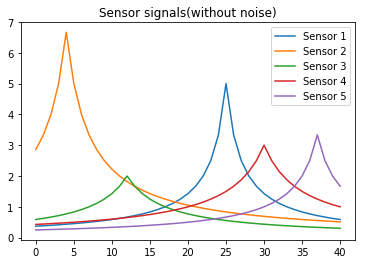

In [5]:
signal_arr = np.zeros((len(sensor_list),X_MAX+1))
for i in range(1,len(sensor_list)):
    sensor = sensor_list[i]
    for x in range(0,X_MAX+1):
        signal_arr[i,x] = sensor.signal(x)
    plt.plot(signal_arr[i,:],label="Sensor " + str(i))
plt.legend()
plt.title("Sensor signals(without noise)")

In [6]:
def sensor_list_print(sensor_list):
    for sensor in sensor_list:
        print(sensor)

## Filtering

In [7]:
def f_process(x,dt):
    return x

In [8]:
def h_measurement(x,sensor):
    return sensor.signal(x)

In [9]:
def ukfilter(x,P,sensor,xa):
    points = MerweScaledSigmaPoints(1, alpha=.001, beta=2., kappa=0)
    dt = 1
    ukf = UnscentedKalmanFilter(dim_x=1, dim_z=1, dt=dt, fx=f_process, hx=h_measurement, points=points)
    ukf.x = x
    ukf.P = P
#     z_std = sensor.variable_noise(xa)
    z_std = sensor.noise
    ukf.R = np.diag([z_std**2])
    ukf.Q = np.diag([0])
    m = 3
    zs = [[sensor.signal(xa)+np.random.randn()*z_std] for i in range(m)]
    for z in zs:
        ukf.predict()
        ukf.update(z,sensor=sensor)
    return ukf.x,ukf.P

## Finite-Horizon Dynamic Programming

In [10]:
X_V = np.arange(0,X_MAX+1)
R_V = np.arange(R_MIN,R_MAX+1)
A_V = np.arange(0,2**len(sensor_list))
K_V = np.arange(0,len(sensor_list)+1)
print("X: ",X_V)
print("R: ",R_V)
print("A: ",A_V)
print("K: ",K_V)

X:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
R:  [-3. -2. -1.  0.  1.  2.  3.  4.]
A:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
K:  [0 1 2 3 4 5 6]


In [11]:
def get_a(selection_list):
    a = 0
    for i in range(0,len(selection_list)):
        a += selection_list[i]*2**(len(sensor_list)-1-i)
    return a

In [12]:
def get_selection_list(a):
    string_list = bin(a)[2:]
    selection_list = [0]*len(sensor_list)
    for i in range(0,len(string_list)):
        selection_list[len(sensor_list)-len(string_list)+i] = int(string_list[i])
    return selection_list

In [13]:
def get_terminal_cost(r):
    ''' Terminal cost is a function of final variance
        Consider a linear function '''
    return 2*r

In [14]:
def get_running_cost(u):
    ''' Running cost is a function of the control
        Corresponds to the sensor cost '''
    if u==0:
        return 0
    else:
        return u.cost

In [15]:
def get_expected_cost(b,sensor,i,r,V,k):
    tot_cost = 0
    for xa in X_V:
        j,s = estimation_simulator(i,r,sensor,xa)
        j_index = np.where(X_V==np.round(j))[0][0]
        s_index = np.where(R_V==np.round(s))[0][0]
        tot_cost += get_running_cost(sensor) + V[k-1][j_index,s_index,b]
    expected_cost = tot_cost/len(X_V)
    return expected_cost

In [16]:
def estimation_simulator(i,r,sensor,xa):
    P = np.exp(r)
    j,S = ukfilter(i,P,sensor,xa)
    if S < 1e-10:
        s=R_MIN
    else:
        s = np.log(S)
    if j>X_MAX:
        j=X_MAX
    if j<0:
        j=0
    if s>R_MAX:
        s=R_MAX
    if s<R_MIN:
        s=R_MIN
    return float(j),float(s)

In [17]:
def initialize_V():
    V = dict()
    V[0] = np.zeros((len(X_V),len(R_V),len(A_V)))
    for idx in range(0,len(R_V)):
        V[0][:,idx,:] = get_terminal_cost(R_V[idx])
    return V

In [18]:
def initialize_mu():
    mu = dict()
    return mu

In [19]:
def a_valid(selection_list,k):
    if sum(selection_list) + k > len(sensor_list):
        return False
    else:
        return True

In [20]:
def DP_step(V,mu,k):
    print("Step: ",k)
    V[k] = np.zeros((len(X_V),len(R_V),len(A_V)))
    mu[k] = np.ones((len(X_V),len(R_V),len(A_V)))*5
    for i in X_V:
        print(i)
        for r_idx in range(0,len(R_V)):
            r = R_V[r_idx]
            for a in A_V:
                selection_list = get_selection_list(a)
                if not a_valid(selection_list,k):
                    continue
                cost_list = list()
                for u_idx in range(0,len(sensor_list)+1):
                    if u_idx == len(sensor_list):
                        cost = V[k-1][i,r_idx,a]
                    elif selection_list[u_idx]:
                        cost = 999999
                    else:
                        selection_list[u_idx] = 1
                        b = get_a(selection_list)
                        sensor = sensor_list[u_idx]
                        cost = get_expected_cost(b,sensor,i,r,V,k)
                    cost_list.append(cost)
                V[k][i,r_idx,a] = np.min(cost_list)
                mu[k][i,r_idx,a] = int(np.argmin(cost_list))
    return V,mu

In [21]:
def finite_horizon_DP(V,mu):
    max_steps = len(sensor_list)
    for k in range(1,max_steps+1):
        V,mu = DP_step(V,mu,k)
    return V,mu

In [22]:
def run_algorithm():
    V = initialize_V()
    mu = initialize_mu()
    V,mu = finite_horizon_DP(V,mu)
    return V,mu

In [62]:
V,mu = run_algorithm()

Step:  1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
Step:  2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
Step:  3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
Step:  4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
Step:  5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
Step:  6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


In [63]:
with open('V40_8.pkl', 'wb') as output:
    pickle.dump(V, output)

In [64]:
with open('mu40_8.pkl', 'wb') as output: 
    pickle.dump(mu, output)

In [23]:
with open("V40_8.pkl", "rb") as fp:
    V = pickle.load(fp)

In [24]:
with open("mu40_8.pkl", "rb") as fp:
    mu = pickle.load(fp)

## Sensor Selection Algorithms

In [25]:
def get_optimal_sensor(mu,k,i,r,a):
    i_index = np.where(X_V==np.round(i))[0][0]
    r_index = np.where(R_V==np.round(r))[0][0]
    a_index = a
    u = mu[k][i_index,r_index,a_index]
    return int(u)

In [26]:
def optimal_location_estimator(i_0,r_0,a_0,mu,xa):
    i = i_0
    r = r_0
    a = a_0
    selection_list = get_selection_list(a)
    total_cost = 0
    max_steps = len(sensor_list)
    for k in range(1,max_steps+1):
        u = get_optimal_sensor(mu,k,i,r,a)
        if u==len(sensor_list):
            continue
        else:
            selection_list[u] = 1
            sensor = sensor_list[u]
            total_cost += sensor.cost
            b = get_a(selection_list)
            j,s = estimation_simulator(i,r,sensor,xa)
            i = j
            r = s
            a = b
    return i,r,total_cost

In [27]:
def allsensors_location_estimator(i_0,r_0,xa):
    i = i_0
    r = r_0
    used_sensors = list()
    total_cost = 0
    for sensor in sensor_list:
        u = sensor
        used_sensors.append(u)
        total_cost += u.cost
        j,s = estimation_simulator(i,r,u,xa)
        i = j
        r = s
    return i,r,total_cost

In [28]:
def cheap_location_estimator(i_0,r_0,xa,BUDGET):
    i = i_0
    r = r_0
    used_sensors = list()
    total_cost = 0
    sensor_costs = list()
    sensor_list_copy = sensor_list.copy()
    for sensor in sensor_list:
        sensor_costs.append(sensor.cost)
    while total_cost < BUDGET and r>R_MIN:
#     while r>R_TERM:
        u = sensor_list_copy[np.argmin(sensor_costs)]
        used_sensors.append(u)
        sensor_list_copy.remove(u)
        sensor_costs.remove(u.cost)
        total_cost += u.cost
        j,s = estimation_simulator(i,r,u,xa)
        i = j
        r = s
    return i,r,total_cost

## Algorithm Comparison

In [29]:
def rms_error(error_vec):
    sq_vec = list()
    for item in error_vec:
        sq_vec.append(item**2)
    return np.sqrt(np.mean(sq_vec))

In [30]:
def algorithm_comparison(num_est):
    i_0 = X_MAX/2
    r_0 = R_MAX
    a_0 = 0
    budget = 3
    e_opt = list()
    e_all = list()
    e_cheap = list()
    r_opt = list()
    r_all = list()
    r_cheap = list()
    c_opt = list()
    c_all = list()
    c_cheap = list()
    
    for k in range(0,num_est):
        xa = np.random.rand()*40
        
        i,r,c = optimal_location_estimator(i_0,r_0,a_0,mu,xa)
        e_opt.append(xa-i)
        r_opt.append(r)
        c_opt.append(c)

        i,r,c = allsensors_location_estimator(i_0,r_0,xa)
        e_all.append(xa-i)
        r_all.append(r)
        c_all.append(c)

        i,r,c = cheap_location_estimator(i_0,r_0,xa,budget)
        e_cheap.append(xa-i)
        r_cheap.append(r)
        c_cheap.append(c)
    
    rms_opt = rms_error(e_opt)
    rms_all = rms_error(e_all)
    rms_cheap = rms_error(e_cheap)
    
    r_mean_opt = np.mean(r_opt)
    r_mean_all = np.mean(r_all)
    r_mean_cheap = np.mean(r_cheap)
    
    c_mean_opt = np.mean(c_opt)
    c_mean_all = np.mean(c_all)
    c_mean_cheap = np.mean(c_cheap)
    
    return rms_opt,rms_all,rms_cheap,r_mean_opt,r_mean_all,r_mean_cheap,c_mean_opt,c_mean_all,c_mean_cheap

In [31]:
rms_opt,rms_all,rms_cheap,r_mean_opt,r_mean_all,r_mean_cheap,c_mean_opt,c_mean_all,c_mean_cheap = algorithm_comparison(10000)

In [32]:
print("OLE(2r)\n==========")
print("RMSE: ",rms_opt)
print("r_mean: ",r_mean_opt)
print("cost_mean: ",c_mean_opt)
print("=================")
print("ASLE\n==========")
print("RMSE: ",rms_all)
print("r_mean: ",r_mean_all)
print("cost_mean: ",c_mean_all)
print("=================")
print("BCLE\n==========")
print("RMSE: ",rms_cheap)
print("r_mean: ",r_mean_cheap)
print("cost_mean: ",c_mean_cheap)

OLE(2r)
RMSE:  13.22195603985613
r_mean:  -2.0106594155847226
cost_mean:  6.4972
ASLE
RMSE:  5.7929302485965675
r_mean:  -2.758835242556873
cost_mean:  18.0
BCLE
RMSE:  5.794715631462032
r_mean:  1.6333799085424545
cost_mean:  3.0


In [32]:
i_0 = 20
r_0 = 4
a_0 = 0
xa = 12
budget = 3

In [33]:
i,r,total_cost,selection_list = optimal_location_estimator(i_0,r_0,a_0,mu,xa)

In [34]:
print("Estimated position: ",i)
print("Estimation variance: ",r)
print("Total incurred cost: ",total_cost)
print("Used sensors: ",selection_list)

Estimated position:  12.434379160371044
Estimation variance:  -3.0
Total incurred cost:  8
Used sensors:  [0, 1, 0, 1, 0, 1]


In [1023]:
i,r,total_cost,selection_list = allsensors_location_estimator(i_0,r_0,xa)

In [1024]:
print("Estimated position: ",i)
print("Estimation variance: ",r)
print("Total incurred cost: ",total_cost)
print("Used sensors: ")
sensor_list_print(selection_list)

Estimated position:  63.29993954595339
Estimation variance:  -1.0708447450686984
Total incurred cost:  12
Used sensors: 
Sensor 0
Sensor 1
Sensor 2
Sensor 3
Sensor 4


In [1025]:
i,r,total_cost,selection_list = cheap_location_estimator(i_0,r_0,xa,budget)

In [1026]:
print("Estimated position: ",i)
print("Estimation variance: ",r)
print("Total incurred cost: ",total_cost)
print("Used sensors: ")
sensor_list_print(selection_list)

Estimated position:  47.41668295424223
Estimation variance:  2.717630979156569
Total incurred cost:  3
Used sensors: 
Sensor 0
Sensor 1
